# Kernel methods for machine learning - image classification challenge

## Imports

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Helper functions

In [43]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid

## Load data

In [3]:
Xtr = np.array(pd.read_csv('data/Xtr.csv', header=None, sep=',', usecols=range(3072)))
Xte = np.array(pd.read_csv('data/Xte.csv', header=None, sep=',', usecols=range(3072)))
Ytr = np.array(pd.read_csv('data/Ytr.csv', sep=',', usecols=[1])).squeeze()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
Ytr

array([8, 9, 3, ..., 1, 7, 5], dtype=int64)

## Visualization

In [5]:
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

X = scale(Xtr)

automobile


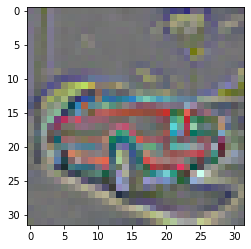

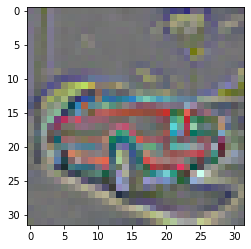

In [6]:
i = 1000
print(classes[Ytr[i]])
tmp = scale(Xtr[i])
r = tmp[:1024].reshape([32, 32])
g = tmp[1024:2048].reshape([32, 32])
b = tmp[2048:].reshape([32, 32])
img = np.dstack((r, g, b))

plt.imshow(scale(img))
plt.show()

tmp = X[i]
r = tmp[:1024].reshape([32, 32])
g = tmp[1024:2048].reshape([32, 32])
b = tmp[2048:].reshape([32, 32])
img = np.dstack((r, g, b))

plt.imshow(scale(img))
plt.show()

## Kernels

In [7]:
class Kernel:
    
    def __init__(self, X, sigma):
        self.X = X
        self.sigma = sigma


class LinearKernel(Kernel):
    
    def __init__(self, X, sigma=None):
        super().__init__(X, sigma)
    
    def similarity_matrix(self):
        l = len(self.X)
        K = np.empty([l, l])
        for i in range(l):
            for j in range(i, l):
                K[i, j] = K[j, i] = np.dot(self.X[i], self.X[j])
        return K
    
    def similarity(self, x):
        return np.array([np.dot(x_i, x) for x_i in self.X])


class GaussianKernel(Kernel):
    
    def __init__(self, X, sigma):
        super().__init__(X, sigma)
    
    def similarity_matrix(self):
        l = len(self.X)
        K = np.empty([l, ll])
        for i in range(ll):
            for j in range(i, ll):
                K[i, j] = K[j, i] = np.exp(-np.linalg.norm(self.X[i] - self.X[j]) ** 2 / (2 * self.sigma ** 2))
        return K
    
    def similarity(self, x):
        return np.array([np.exp(-np.linalg.norm(x_i - x) ** 2 / (2 * self.sigma ** 2)) for x_i in self.X])
    

kernels = {'linear': LinearKernel, 'rbf': GaussianKernel}

## Algorithms

In [58]:
class KernelRidgeClassifier(BaseEstimator):
    
    def __init__(self, C=1.0, kernel='rbf', sigma=10):
        self.C = C
        self.kernel = kernel
        self.sigma = sigma
    
    def fit(self, X, y):
        # map labels in {-1, 1}
        Y = LabelBinarizer(pos_label=1, neg_label=-1).fit_transform(y)
        # initialize kernel
        self.K = kernels[self.kernel](X, self.sigma)
        K = self.K.similarity_matrix()
        # get second term of KRR
        diag = np.zeros_like(K)
        np.fill_diagonal(diag, self.C * len(X))
        # compute coefficients for each class, one-vs-all
        # @ is matrix multiplication, equivalent to np.matmul
        self.alpha = []
        for c in sorted(set(y)):
            self.alpha.append(np.linalg.inv(K + diag) @ Y[:,c])
        self.alpha = np.array(self.alpha)
        return self
    
    def predict(self, X):
        preds = []
        for x in X:
            similarity = self.K.similarity(x)
            preds.append(np.argmax([np.sum([alpha * similarity for a in alpha]) for alpha in self.alpha]))
        return np.array(preds)

## Training

Kernel ridge regression with linear kernel:

In [74]:
clf = KernelRidgeClassifier(kernel='linear')
start = time.time()
clf.fit(Xtr, Ytr)
end = time.time()
print(f"fit completed in {end - start} seconds")

fit completed in 825.3642325401306 seconds


With cross-validation:

In [71]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
ridge = KernelRidgeClassifier(kernel='linear')
params = {'C': [0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(ridge, params, scoring='accuracy', cv=skf ,verbose=5)
clf.fit(Xtr, Ytr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 

In [ ]:
print(clf.best_params_)
clf.predict(Xte)

## Predict and export

In [ ]:
Yte = clf.predict(Xte)

In [ ]:
Yte = {'Prediction' : Yte}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('Yte_pred.csv',index_label='Id')

## Tests

In [45]:
from sklearn.datasets import make_classification

In [64]:
X, y = make_classification(n_informative=5, n_classes=10)
y

In [65]:
clf = KernelRidgeClassifier(kernel='linear')
clf.fit(X, y)
clf.predict(X)

KernelRidgeClassifier(kernel='linear')

In [68]:
clf = RidgeClassifier()
clf.fit(X, y)
clf.predict(X)

RidgeClassifier()